# Introduction

Since Jan. 1, 2015, [The Washington Post](https://www.washingtonpost.com/) has been compiling a database of every fatal shooting in the US by a police officer in the line of duty. 

<center><img src=https://i.imgur.com/sX3K62b.png></center>

While there are many challenges regarding data collection and reporting, The Washington Post has been tracking more than a dozen details about each killing. This includes the race, age and gender of the deceased, whether the person was armed, and whether the victim was experiencing a mental-health crisis. The Washington Post has gathered this supplemental information from law enforcement websites, local new reports, social media, and by monitoring independent databases such as "Killed by police" and "Fatal Encounters". The Post has also conducted additional reporting in many cases.

There are 4 additional datasets: US census data on poverty rate, high school graduation rate, median household income, and racial demographics. [Source of census data](https://factfinder.census.gov/faces/nav/jsf/pages/community_facts.xhtml).

## Import Statements

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# This might be helpful:
from collections import Counter

## Notebook Presentation

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

## Load the Data

In [3]:
df_hh_income = pd.read_csv('Median_Household_Income_2015.csv', encoding="windows-1252")
df_pct_poverty = pd.read_csv('Pct_People_Below_Poverty_Level.csv', encoding="windows-1252")
df_pct_completed_hs = pd.read_csv('Pct_Over_25_Completed_High_School.csv', encoding="windows-1252")
df_share_race_city = pd.read_csv('Share_of_Race_By_City.csv', encoding="windows-1252")
df_fatalities = pd.read_csv('Deaths_by_Police_US.csv', encoding="windows-1252")

# Preliminary Data Exploration

* What is the shape of the DataFrames? 
* How many rows and columns do they have?
* What are the column names?
* Are there any NaN values or duplicates?

In [4]:
print('Household income shape:', df_hh_income.shape)
print('Poverty share shape:', df_pct_poverty.shape)
print('High school graduation shape:', df_pct_completed_hs.shape)
print('Racial distribution shape:', df_share_race_city.shape)
print('Fatalities shape:', df_fatalities.shape)

Household income shape: (29322, 3)
Poverty share shape: (29329, 3)
High school graduation shape: (29329, 3)
Racial distribution shape: (29268, 7)
Fatalities shape: (2535, 14)


In [5]:
print('Household income columns:', df_hh_income.columns)
print('Poverty share columns:', df_pct_poverty.columns)
print('High school graduation columns:', df_pct_completed_hs.columns)
print('Racial distribution columns:', df_share_race_city.columns)
print('Fatalities columns:', df_fatalities.columns)

Household income columns: Index(['Geographic Area', 'City', 'Median Income'], dtype='object')
Poverty share columns: Index(['Geographic Area', 'City', 'poverty_rate'], dtype='object')
High school graduation columns: Index(['Geographic Area', 'City', 'percent_completed_hs'], dtype='object')
Racial distribution columns: Index(['Geographic area', 'City', 'share_white', 'share_black',
       'share_native_american', 'share_asian', 'share_hispanic'],
      dtype='object')
Fatalities columns: Index(['id', 'name', 'date', 'manner_of_death', 'armed', 'age', 'gender',
       'race', 'city', 'state', 'signs_of_mental_illness', 'threat_level',
       'flee', 'body_camera'],
      dtype='object')


In [6]:
print('Household income NA values:', df_hh_income.isna().sum())
print('\nPoverty share NA values:', df_pct_poverty.isna().sum())
print('\nHigh school graduation NA values:', df_pct_completed_hs.isna().sum())
print('\nRacial distribution NA values:', df_share_race_city.isna().sum())
print('\nFatalities NA values:', df_fatalities.isna().sum())

Household income NA values: Geographic Area     0
City                0
Median Income      51
dtype: int64

Poverty share NA values: Geographic Area    0
City               0
poverty_rate       0
dtype: int64

High school graduation NA values: Geographic Area         0
City                    0
percent_completed_hs    0
dtype: int64

Racial distribution NA values: Geographic area          0
City                     0
share_white              0
share_black              0
share_native_american    0
share_asian              0
share_hispanic           0
dtype: int64

Fatalities NA values: id                           0
name                         0
date                         0
manner_of_death              0
armed                        9
age                         77
gender                       0
race                       195
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                        65
body_

In [7]:
print('Household income duplicates:', df_hh_income.duplicated().sum())
print('Poverty share duplicates:', df_pct_poverty.duplicated().sum())
print('High school graduation duplicates:', df_pct_completed_hs.duplicated().sum())
print('Racial distribution duplicates:', df_share_race_city.duplicated().sum())
print('Fatalities duplicates:', df_fatalities.duplicated().sum())

Household income duplicates: 0
Poverty share duplicates: 0
High school graduation duplicates: 0
Racial distribution duplicates: 0
Fatalities duplicates: 0


# Merge Datasets

In [8]:
df_demographics = df_pct_poverty.merge(df_hh_income, how='outer', on=['City', 'Geographic Area'])
df_demographics = df_demographics.merge(df_share_race_city, how='outer', left_on=['City', 'Geographic Area'], right_on=['City', 'Geographic area'])
df_demographics = df_demographics.merge(df_pct_completed_hs, how='outer', on=['City', 'Geographic Area'])

len1, len2, len3, len4, len5 = len(df_pct_poverty), len(df_hh_income), len(df_share_race_city), len(df_pct_completed_hs), len(df_demographics)
print('Length of dataframes before merges:', len1, len2, len3, len4)
print('Length of dataframe after merges:', len5)

Length of dataframes before merges: 29329 29322 29268 29329
Length of dataframe after merges: 29477


## Data Cleaning - Check for Missing Values and Duplicates

Consider how to deal with the NaN values. Perhaps substituting 0 is appropriate. 

In [9]:
# Not sure why the City column is like that
df_demographics.head(10)

,Geographic Area,City,poverty_rate,Median Income,Geographic area,share_white,share_black,share_native_american,share_asian,share_hispanic,percent_completed_hs
0,AL,Abanda CDP,78.8,11207,AL,67.2,30.2,0,0,1.6,21.2
1,AL,Abbeville city,29.1,25615,AL,54.4,41.4,0.1,1,3.1,69.1
2,AL,Adamsville city,25.5,42575,AL,52.3,44.9,0.5,0.3,2.3,78.9
3,AL,Addison town,30.7,37083,AL,99.1,0.1,0,0.1,0.4,81.4
4,AL,Akron town,42,21667,AL,13.2,86.5,0,0,0.3,68.6
5,AL,Alabaster city,11.2,71816,AL,79.4,13.5,0.4,0.9,9,89.3
6,AL,Albertville city,26.7,32911,AL,75.9,1.9,0.8,0.5,27.9,72.7
7,AL,Alexander City city,30.4,29874,AL,62.2,32,0.2,0.9,4.8,78.1
8,AL,Alexandria CDP,9.7,56058,AL,87.4,10.2,0.3,0.5,0.9,88.8
9,AL,Aliceville city,41.3,21131,AL,22.6,74.9,0.1,0,1.2,74.3


In [10]:
# Add 'city' to Carson City so name is preserved in next step
for idx, row in df_demographics.iterrows():
    if row['City'] == 'Carson City':
        row['City'] = 'Carson City drop_this_string'

# Clean City column
#   Note: There are edge cases in the column that still need to be cleaned; however, I ignore these since they are dropped after the merge
trimmed_city = [' '.join(city.split(' ')[:-1]) for city in df_demographics['City']]
df_demographics['Trimmed City'] = trimmed_city
df_demographics.head()

,Geographic Area,City,poverty_rate,Median Income,Geographic area,share_white,share_black,share_native_american,share_asian,share_hispanic,percent_completed_hs,Trimmed City
0,AL,Abanda CDP,78.8,11207,AL,67.2,30.2,0,0,1.6,21.2,Abanda
1,AL,Abbeville city,29.1,25615,AL,54.4,41.4,0.1,1,3.1,69.1,Abbeville
2,AL,Adamsville city,25.5,42575,AL,52.3,44.9,0.5,0.3,2.3,78.9,Adamsville
3,AL,Addison town,30.7,37083,AL,99.1,0.1,0,0.1,0.4,81.4,Addison
4,AL,Akron town,42,21667,AL,13.2,86.5,0,0,0.3,68.6,Akron


In [11]:
# Merge fatalities and income datasets
df = df_fatalities.merge(df_demographics, how='left', left_on=['city', 'state'], right_on=['Trimmed City', 'Geographic Area'], )
df = df.drop(columns=['id', 'Geographic Area', 'Geographic area', 'City', 'Trimmed City'])
df = df.rename(columns={'Median Income': 'median_income'})

In [12]:
for col in df.columns:
    print(col, (df[col].isna().sum()))

name 0
date 0
manner_of_death 0
armed 9
age 78
gender 0
race 196
city 0
state 0
signs_of_mental_illness 0
threat_level 0
flee 65
body_camera 0
poverty_rate 289
median_income 303
share_white 291
share_black 291
share_native_american 291
share_asian 291
share_hispanic 291
percent_completed_hs 289


In [13]:
# Convert column of strings (with NaN and '(X)' values) to integers.
income_str_list = df['median_income']
income_list = []
for income in income_str_list:
    try:
        income_int = int(income)
    except ValueError:
        income_int = np.nan
    income_list.append(income_int)

# Impute missing values with median income
df['median_income'] = income_list
median_income = df['median_income'].median()
df['median_income'] = df['median_income'].fillna(median_income)

In [14]:
# Cast string columns as floats
df['poverty_rate'] = [float(i) for i in df['poverty_rate']]
df['share_white'] = [float(i) for i in df['share_white']]
df['share_black'] = [float(i) for i in df['share_black']]
df['share_native_american'] = [float(i) for i in df['share_native_american']]
df['share_asian'] = [float(i) for i in df['share_asian']]
df['share_hispanic'] = [float(i) for i in df['share_hispanic']]
df['percent_completed_hs'] = [float(i) for i in df['percent_completed_hs']]

# While at it, fill NaN in continuous variables with median value
df['age'] = df['age'].fillna(df['age'].median())
df['poverty_rate'] = df['poverty_rate'].fillna(df['poverty_rate'].median())
df['share_white'] = df['share_white'].fillna(df['share_white'].median())
df['share_black'] = df['share_black'].fillna(df['share_black'].median())
df['share_native_american'] = df['share_native_american'].fillna(df['share_native_american'].median())
df['share_asian'] = df['share_asian'].fillna(df['share_asian'].median())
df['share_hispanic'] = df['share_hispanic'].fillna(df['share_hispanic'].median())
df['percent_completed_hs'] = df['percent_completed_hs'].fillna(df['percent_completed_hs'].median())

In [15]:
# Drop all remaining NaN values in categorical columns
df = df.dropna()
df

,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,...,flee,body_camera,poverty_rate,median_income,share_white,share_black,share_native_american,share_asian,share_hispanic,percent_completed_hs
0,Tim Elliot,02/01/15,shot,gun,53.00,M,A,Shelton,WA,True,...,Not fleeing,False,28.60,"37,072.00",78.90,0.80,3.70,1.10,19.20,80.10
1,Lewis Lee Lembke,02/01/15,shot,gun,47.00,M,W,Aloha,OR,False,...,Not fleeing,False,14.90,"65,765.00",70.90,2.60,1.00,8.90,21.10,88.10
2,John Paul Quintero,03/01/15,shot and Tasered,unarmed,23.00,M,H,Wichita,KS,False,...,Not fleeing,False,17.30,"45,947.00",71.90,11.50,1.20,4.80,15.30,87.50
3,Matthew Hoffman,04/01/15,shot,toy weapon,32.00,M,W,San Francisco,CA,True,...,Not fleeing,False,13.20,"81,294.00",48.50,6.10,0.50,33.30,15.10,87.00
4,Michael Rodriguez,04/01/15,shot,nail gun,39.00,M,H,Evans,CO,False,...,Not fleeing,False,16.60,"47,791.00",76.50,0.90,1.20,0.90,43.10,76.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530,Kesharn K. Burney,26/07/17,shot,vehicle,25.00,M,B,Dayton,OH,False,...,Car,False,35.50,"27,683.00",51.70,42.90,0.30,0.90,3.00,82.10
2532,Deltra Henderson,27/07/17,shot,gun,39.00,M,B,Homer,LA,False,...,Car,False,40.00,"27,050.00",33.00,64.30,0.10,0.80,1.40,79.00
2535,Alejandro Alvarado,27/07/17,shot,knife,34.00,M,H,Chowchilla,CA,False,...,Not fleeing,False,32.10,"34,559.00",61.60,12.60,2.00,2.10,37.80,68.30
2540,Isaiah Tucker,31/07/17,shot,vehicle,28.00,M,B,Oshkosh,WI,False,...,Car,True,17.90,"42,650.00",90.50,3.10,0.80,3.20,2.70,89.30


# Chart the Poverty Rate in each US State

Create a bar chart that ranks the poverty rate from highest to lowest by US state. Which state has the highest poverty rate? Which state has the lowest poverty rate?  Bar Plot

#### NOTE: The data is not appropriate for calculating state-level poverty rates. We just have city-level data without a population variable; therefore, New York City, NY is given equal weight as New York Mills, NY. Instead, we should adjust for population to get a person-level measure aggreated to the state level. This problem persists for all of such state-level questions below

In [16]:
# Clean data for entire dataset (was not necessary previously when merge removed cities with missing data)
rate_list = []
for rate in df_pct_poverty['poverty_rate']:
    rate = rate.replace('-', '')
    if rate == '':
        rate = np.nan
    else:
        rate = float(rate)
    rate_list.append(rate)
df_pct_poverty['poverty_rate'] = rate_list

In [17]:
# Group poverty rates by state, return only top and bottom 5
df_pct_poverty_state = df_pct_poverty.groupby('Geographic Area').mean()
df_pct_poverty_state = df_pct_poverty_state.sort_values(by='poverty_rate', ascending=False)
df_pct_poverty_state = pd.concat([df_pct_poverty_state.head(5), df_pct_poverty_state.tail(5)])

<BarContainer object of 10 artists>

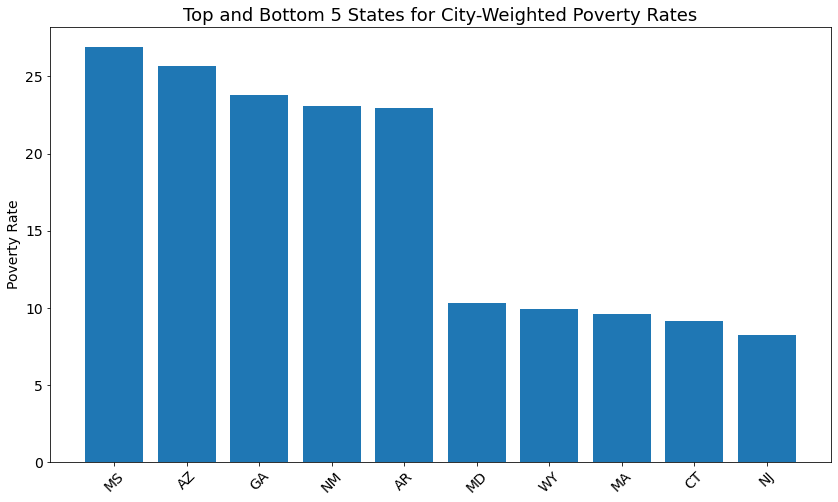

In [18]:
plt.figure(figsize=(14,8))
plt.title('Top and Bottom 5 States for City-Weighted Poverty Rates', fontsize=18)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.ylabel('Poverty Rate', fontsize=14)

plt.bar(df_pct_poverty_state['poverty_rate'].index, df_pct_poverty_state['poverty_rate'].values)

# Chart the High School Graduation Rate by US State

Show the High School Graduation Rate in ascending order of US States. Which state has the lowest high school graduation rate? Which state has the highest?

In [22]:
# Clean data for entire dataset (was not necessary previously when merge removed cities with missing data)
hs_list = []
for hs in df_pct_completed_hs['percent_completed_hs']:
    hs = hs.replace('-', '')
    if hs == '':
        hs = np.nan
    else:
        hs = float(hs)
    hs_list.append(hs)
df_pct_completed_hs['percent_completed_hs'] = hs_list

In [23]:
# Group poverty rates by state, return only top and bottom 5
df_pct_completed_hs_state = df_pct_completed_hs.groupby('Geographic Area').mean()
df_pct_completed_hs_state = df_pct_completed_hs_state.sort_values(by='percent_completed_hs', ascending=False)
df_pct_completed_hs_state = pd.concat([df_pct_completed_hs_state.head(5), df_pct_completed_hs_state.tail(5)])

<BarContainer object of 10 artists>

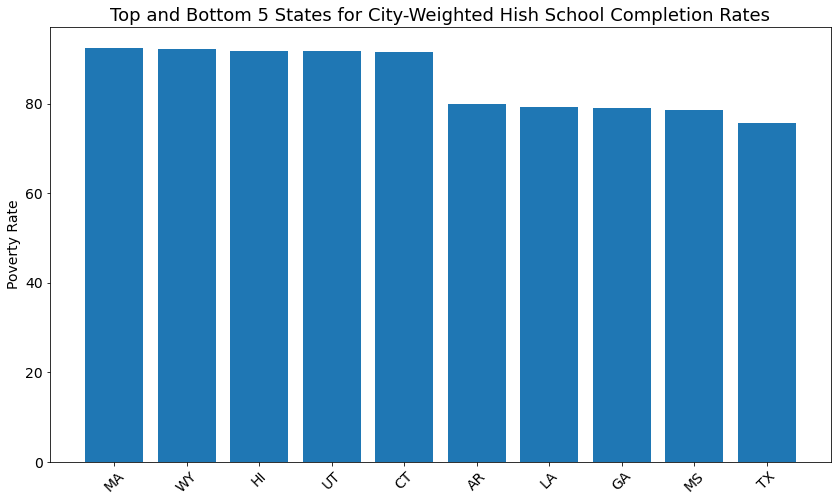

In [24]:
plt.figure(figsize=(14,8))
plt.title('Top and Bottom 5 States for City-Weighted High School Completion Rates', fontsize=18)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.ylabel('High School Completion Rate', fontsize=14)

plt.bar(df_pct_completed_hs_state['percent_completed_hs'].index, df_pct_completed_hs_state['percent_completed_hs'].values)

# Visualise the Relationship between Poverty Rates and High School Graduation Rates

#### Create a line chart with two y-axes to show if the rations of poverty and high school graduation move together.

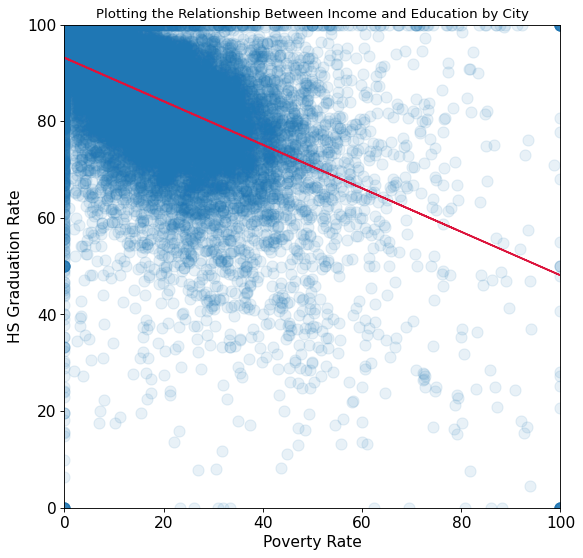

In [57]:
# Merge datasets
df_poverty_hs = df_pct_poverty.merge(df_pct_completed_hs, how='inner', on=['City', 'Geographic Area'])
df_poverty_hs = df_poverty_hs.dropna()

# Plot relationship
plt.figure(figsize=(8,8), dpi=80)
plt.title('Plotting the Relationship Between Income and Education by City')

plt.xlabel('Poverty Rate', fontsize=14)
plt.ylabel('HS Graduation Rate', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax = plt.gca()
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

# Scatter plot!
plt.scatter(x=df_poverty_hs['poverty_rate'], y=df_poverty_hs['percent_completed_hs'], alpha=0.1, s=100)

# Add line of best fit
reg = np.polyfit(df_poverty_hs['poverty_rate'], df_poverty_hs['percent_completed_hs'], 1)
b1, b0 = reg[0], reg[1]
pred_y = b0 + b1*df_poverty_hs['poverty_rate']
plt.plot(df_poverty_hs['poverty_rate'], pred_y, c='crimson')

#### Now use a Seaborn .jointplot() with a Kernel Density Estimate (KDE) and/or scatter plot to visualise the same relationship

#### Seaborn's `.lmplot()` or `.regplot()` to show a linear regression between the poverty ratio and the high school graduation ratio. 

# Create a Bar Chart with Subsections Showing the Racial Makeup of Each US State

Visualise the share of the white, black, hispanic, asian and native american population in each US State using a bar chart with sub sections. 

# Create Donut Chart by of People Killed by Race

Hint: Use `.value_counts()`

# Create a Chart Comparing the Total Number of Deaths of Men and Women

Use `df_fatalities` to illustrate how many more men are killed compared to women. 

# Create a Box Plot Showing the Age and Manner of Death

Break out the data by gender using `df_fatalities`. Is there a difference between men and women in the manner of death? 

# Were People Armed? 

In what percentage of police killings were people armed? Create chart that show what kind of weapon (if any) the deceased was carrying. How many of the people killed by police were armed with guns versus unarmed? 

# How Old Were the People Killed?

Work out what percentage of people killed were under 25 years old.  

Create a histogram and KDE plot that shows the distribution of ages of the people killed by police. 

Create a seperate KDE plot for each race. Is there a difference between the distributions? 

# Race of People Killed

Create a chart that shows the total number of people killed by race. 

# Mental Illness and Police Killings

What percentage of people killed by police have been diagnosed with a mental illness?

# In Which Cities Do the Most Police Killings Take Place?

Create a chart ranking the top 10 cities with the most police killings. Which cities are the most dangerous?  

# Rate of Death by Race

Find the share of each race in the top 10 cities. Contrast this with the top 10 cities of police killings to work out the rate at which people are killed by race for each city. 

# Create a Choropleth Map of Police Killings by US State

Which states are the most dangerous? Compare your map with your previous chart. Are these the same states with high degrees of poverty? 

# Number of Police Killings Over Time

Analyse the Number of Police Killings over Time. Is there a trend in the data? 

# Epilogue

Now that you have analysed the data yourself, read [The Washington Post's analysis here](https://www.washingtonpost.com/graphics/investigations/police-shootings-database/).